# **Классификация текстов по представлениям из трансформера**

В данной работе исследовалась задача классификации текстов обычными ML моделями на базе DL-представлений.

В качестве трансформеров были выбраны модели **BERT** и **ELECTRA**

In [1]:
import numpy as np

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

In [2]:
!pip install datasets
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 346 kB 5.3 MB/s 
     |████████████████████████████████| 140 kB 45.4 MB/s 
     |████████████████████████████████| 1.1 MB 39.3 MB/s 
     |████████████████████████████████| 86 kB 5.0 MB/s 
     |████████████████████████████████| 86 kB 3.8 MB/s 
     |████████████████████████████████| 212 kB 46.5 MB/s 
     |████████████████████████████████| 596 kB 39.7 MB/s 
     |████████████████████████████████| 127 kB 62.6 MB/s 
     |████████████████████████████████| 271 kB 40.3 MB/s 
     |████████████████████████████████| 144 kB 44.8 MB/s 
     |████████████████████████████████| 94 kB 3.0 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
     

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 4.9 MB/s 
     |████████████████████████████████| 6.6 MB 41.0 MB/s 


В качестве задачи выберем датасет SST-2, решающий проблему токсичности комментариев к фильмам (бинарная классификация). Точность будем мерить по метрике accuracy (набор данных является сбалансированным). 

In [3]:
from datasets import load_dataset
dataset = load_dataset('glue', 'sst2')

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

Dataset glue downloaded and prepared to /root/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 872
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1821
    })
})

In [ ]:
(np.array(dataset['train']['label']) == 1).sum(), (np.array(dataset['train']['label']) == 0).sum()

(37569, 29780)

Используем токенезатор BERT, чтобы представить данные слова в числах. Также используем дополнительные токены для паддинга и спец. токен $<clc>$

In [4]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

vocab_size = len(tokenizer.vocab)
print(vocab_size)

max_length=128

30522


In [5]:
train_ids, test_ids = [], []

In [6]:
for sent in dataset['train']['sentence']:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_length,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = False,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    train_ids.append(encoded_dict['input_ids'])

for sent in dataset['validation']['sentence']:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_length,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = False,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )   
    test_ids.append(encoded_dict['input_ids'])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [7]:
train_ids = torch.cat(train_ids, dim=0)
test_ids = torch.cat(test_ids, dim=0)
train_labels = torch.tensor(dataset['train']['label'])
test_labels = torch.tensor(dataset['validation']['label'])

In [12]:
train_dataset = TensorDataset(train_ids, train_labels)
test_dataset = TensorDataset(test_ids, test_labels)

train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=512, shuffle=True)

# BERT

Загрузим предобученный BERT

In [9]:
from transformers import BertForSequenceClassification

In [10]:
bert = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = True, # Whether the model returns all hidden-states.
)

for p in bert.parameters():
    p.requires_grad = False

pytorch_total_params = sum(p.numel() for p in bert.parameters() if p.requires_grad)
print('BERT parameters: ', pytorch_total_params)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BERT parameters:  0


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert = bert.to(device)

В качестве представлений будем брать выходы с последнего слоя трансформера. Он для каждого токена получает его контекстные эмбеддинги. Таким образом, получим, что каждое предложение представляет из себя матрицу $token\times embedding$. Но модели машинного обучения работают с одномерными векторами. Мы попробуем три разные стратегии взятия информации из трансформеров: среднее по токенам, среднее по эмбеддингам(каналам) и первый токен, отвечающий за класс.

In [38]:
X_train_tokens, X_test_tokens, X_train_channels, X_test_channels, X_train_clc, X_test_clc = [], [], [], [], [], []
for idx, (inputs, labels) in enumerate(train_dataloader):
    inputs, labels = inputs.to(device), labels.to(device)
    out_bert = bert(inputs)[1][-1]
    X_train_tokens.append(out_bert.mean(axis=1).cpu())
    X_train_channels.append(out_bert.mean(axis=2).cpu())
    X_train_clc.append(out_bert[:, 0].cpu())

for idx, (inputs, labels) in enumerate(test_dataloader):
    inputs, labels = inputs.to(device), labels.to(device)
    out_bert = bert(inputs)[1][-1]
    X_test_tokens.append(out_bert.mean(axis=1).cpu())
    X_test_channels.append(out_bert.mean(axis=2).cpu())
    X_test_clc.append(out_bert[:, 0].cpu())

In [39]:
X_train_tokens = torch.cat(X_train_tokens, dim=0)
X_train_channels = torch.cat(X_train_channels, dim=0)
X_train_clc = torch.cat(X_train_clc, dim=0)

X_test_tokens = torch.cat(X_test_tokens, dim=0)
X_test_channels = torch.cat(X_test_channels, dim=0)
X_test_clc = torch.cat(X_test_clc, dim=0)

In [40]:
X_train_tokens.shape, X_test_tokens.shape, X_train_channels.shape, X_test_channels.shape, X_train_clc.shape, X_test_clc.shape

(torch.Size([67349, 768]),
 torch.Size([872, 768]),
 torch.Size([67349, 128]),
 torch.Size([872, 128]),
 torch.Size([67349, 768]),
 torch.Size([872, 768]))

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
PATH = '../content/drive/MyDrive/'

In [41]:
torch.save(X_train_tokens, PATH + "X_train_bert_tokens")
torch.save(X_train_channels, PATH + "X_train_bert_channels")
torch.save(X_train_clc, PATH + "X_train_bert_clc")

torch.save(X_test_tokens, PATH + "X_test_bert_tokens")
torch.save(X_test_channels, PATH + "X_test_bert_channels")
torch.save(X_test_clc, PATH + "X_test_bert_clc")

## Среднее по токенам

Загрузка данных

In [ ]:
X = torch.load(PATH + "X_train_bert_tokens", map_location=torch.device('cpu'))
X_test = torch.load(PATH + "X_test_bert_tokens", map_location=torch.device('cpu'))

In [6]:
y = np.array(dataset['train']['label'])
y_test = np.array(dataset['validation']['label'])

In [ ]:
X.shape, y.shape, X_test.shape, y_test.shape

(torch.Size([67349, 768]), (67349,), torch.Size([872, 768]), (872,))

In [7]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

Разделим обучающую выборку  на валидацию и обучение для подбора гиперпараметров наших моделей

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.15, shuffle=True, random_state=10)

In [ ]:
y_train.shape, y_val.shape

((57246,), (10103,))

Необходимые функции для проверки качества, отрисовки графиков и подбора параметров

In [8]:
def scorer(estimator, X, y):
    return accuracy_score(y, estimator.predict(X))

In [9]:
def plot(train, val, param_name, param_values, name):
    plt.figure(figsize=(10, 5))
    plt.title(f'{name} accuracy', fontsize=15)
    plt.xlabel(f'{param_name}', fontsize=15)
    plt.ylabel('Accuracy', fontsize=15)
    plt.plot(param_values, train, label='train')
    plt.plot(param_values, val, label='val')
    plt.legend()
    plt.grid(True)
    if (param_name == 'C') | (param_name == 'learning_rate'):
        plt.xscale("log")

In [10]:
def get_best_parameter(estimator, name, X_train, y_train, X_val, y_val, param_name, param_values, args={}):
    train_acc, val_acc = [], []
    for value in param_values:
        args[param_name] = value
        estim = estimator(**args)
        estim.fit(X_train, y_train)
        train_acc.append(scorer(estim, X_train, y_train))
        val_acc.append(scorer(estim, X_val, y_val))
    plot(train_acc, val_acc, param_name, param_values, name)
    return max(val_acc), param_values[np.array(val_acc).argmax()]

In [11]:
def print_res(estimator, X_train, y_train, X_test, y_test, estimator_name):
    estimator.fit(X_train, y_train)
    print(f'{estimator_name} train accuracy: {scorer(estimator, X_train, y_train)}')
    print(f'{estimator_name} test accuracy: {scorer(estimator, X_test, y_test)}')

Для начала попробуем разные модели машинного обучения: kNN, лог. регрессию и градиентный бустинг

### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

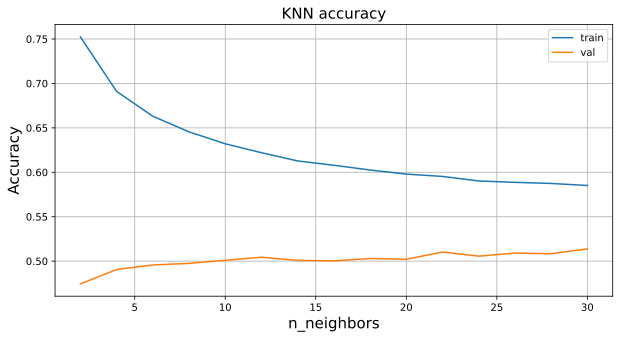

In [ ]:
best_score, best_param = get_best_parameter(KNeighborsClassifier, 'KNN', X_train, y_train, X_val, y_val, "n_neighbors", range(2, 31, 2))

In [ ]:
best_score, best_param

(0.5138077798673661, 30)

In [ ]:
print_res(KNeighborsClassifier(n_neighbors=best_param), X, y, X_test, y_test, "KNN")

KNN train accuracy: 0.5822209683885433
KNN test accuracy: 0.4908256880733945


### LogisticRegression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
import warnings
warnings.filterwarnings("ignore")

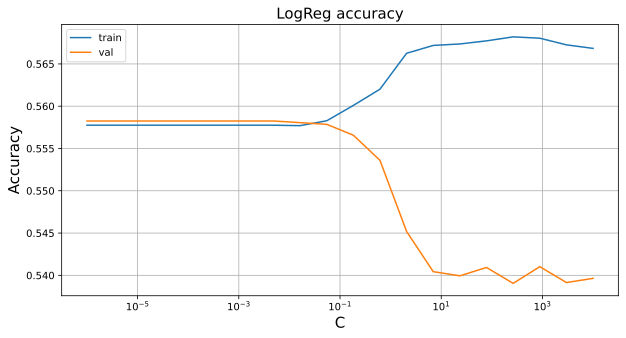

In [ ]:
best_score, best_param = get_best_parameter(LogisticRegression, 'LogReg', X_train, y_train, X_val, y_val, "C", np.logspace(-6, 4, 20), {'max_iter': 1000})

In [ ]:
best_score, best_param

(0.5582500247451252, 1e-06)

In [ ]:
print_res(LogisticRegression(max_iter=1000, C=best_param), X, y, X_test, y_test, "LogReg")

LogReg train accuracy: 0.5653536058441848
LogReg test accuracy: 0.5172018348623854


### Gradient Boosting

In [13]:
from lightgbm import LGBMClassifier

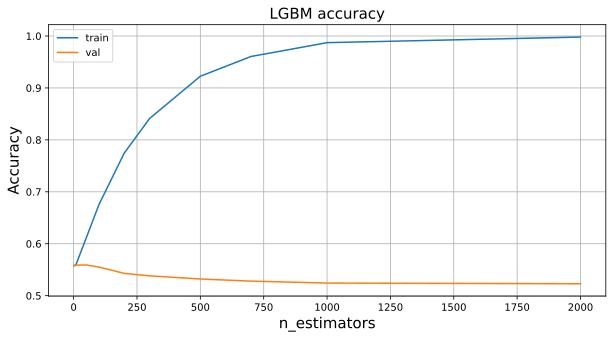

In [ ]:
n_estimators = [1, 5, 10, 50, 70, 100, 200, 300, 500, 700, 1000, 2000]
best_score, best_param = get_best_parameter(LGBMClassifier, 'LGBM', X_train, y_train, X_val, y_val, "n_estimators", n_estimators)

In [ ]:
best_score, best_param

(0.5591408492526972, 70)

Видим, что модель сильно переобучается при слишком большом количестве деревьев.

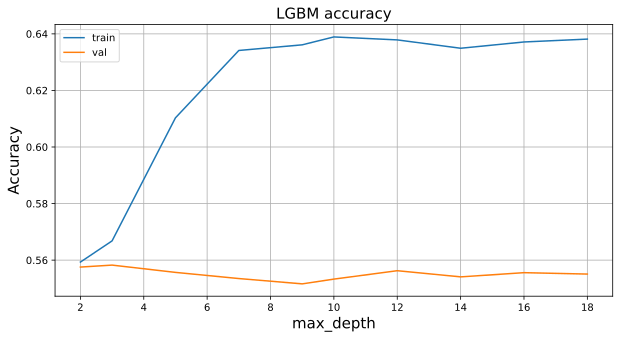

In [ ]:
max_depth = np.linspace(2, 18, 10).astype('int')
params = {'n_estimators': 70}
best_score, best_param = get_best_parameter(LGBMClassifier, 'LGBM', X_train, y_train, X_val, y_val, "max_depth", max_depth, params)

В зависимости от глубины точность примерно одинаковая на валидации. Возьмём деревья поглубже, чтобы лучше запомнить обучающую выборку.

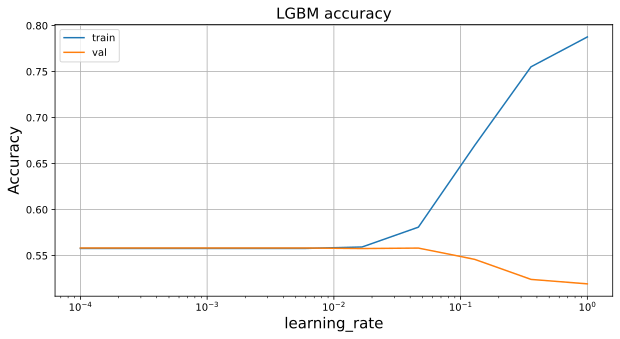

In [ ]:
learning_rate = np.logspace(-4, 0, 10)
params['max_depth'] = 18
best_score, best_param = get_best_parameter(LGBMClassifier, 'LGBM', X_train, y_train, X_val, y_val, "learning_rate", learning_rate, params)

In [ ]:
best_score, best_param

(0.5582500247451252, 0.0001)

In [ ]:
params['learning_rate'] = best_param
print_res(LGBMClassifier(**params), X, y, X_test, y_test, "LGBM")

LGBM train accuracy: 0.6263790108242142
LGBM test accuracy: 0.5206422018348624


Можно заключить, что все модели одинаково плохо обучаются и выдают случайный результат. Они не способны показать хорошее качество на тесте. Всюду далее везде будем использовать бустинг в качестве ML модели.

## Среднее по каналам

In [ ]:
X = torch.load(PATH + "X_train_bert_channels", map_location=torch.device('cpu'))
X_test = torch.load(PATH + "X_test_bert_channels", map_location=torch.device('cpu'))

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.15, shuffle=True, random_state=10)

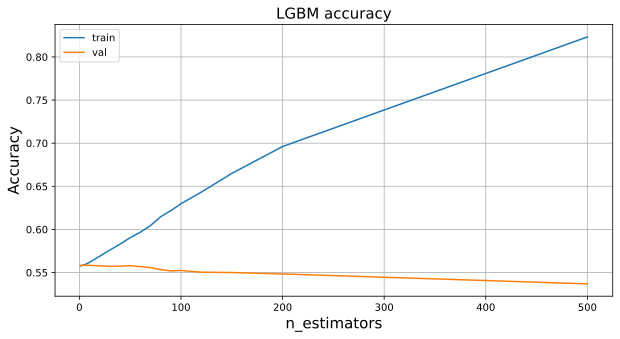

In [ ]:
n_estimators = [1, 5, 10, 30, 40, 50, 60, 70, 80, 90, 100, 120, 150, 200, 500]
best_score, best_param = get_best_parameter(LGBMClassifier, 'LGBM', X_train, y_train, X_val, y_val, "n_estimators", n_estimators)

In [ ]:
best_score, best_param

(0.5585469662476492, 50)

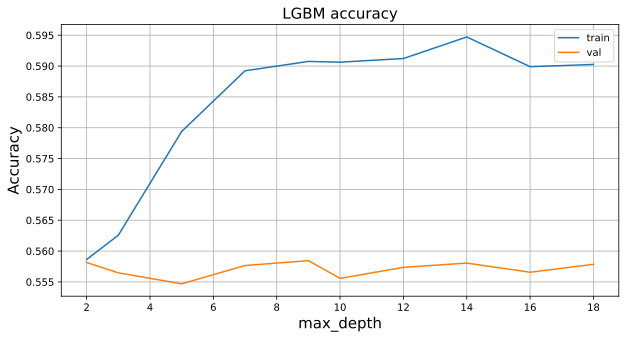

In [ ]:
max_depth = np.linspace(2, 18, 10).astype('int')
params = {'n_estimators': 50}
best_score, best_param = get_best_parameter(LGBMClassifier, 'LGBM', X_train, y_train, X_val, y_val, "max_depth", max_depth, params)

In [ ]:
best_score, best_param

(0.5584479857468079, 9)

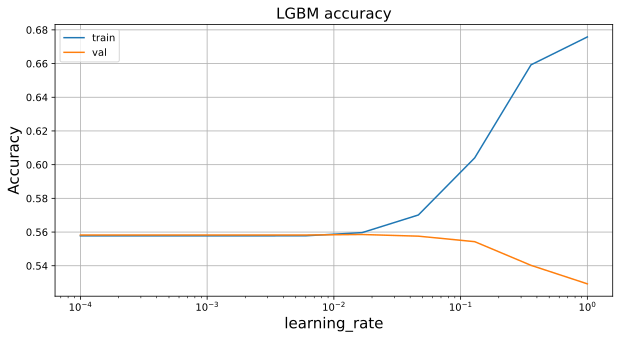

In [ ]:
learning_rate = np.logspace(-4, 0, 10)
params['max_depth'] = 9
best_score, best_param = get_best_parameter(LGBMClassifier, 'LGBM', X_train, y_train, X_val, y_val, "learning_rate", learning_rate, params)

In [ ]:
best_score, best_param

(0.5585469662476492, 0.016681005372000592)

In [ ]:
params['learning_rate'] = best_param
print_res(LGBMClassifier(**params), X, y, X_test, y_test, "LGBM")

LGBM train accuracy: 0.5595331779239484
LGBM test accuracy: 0.5068807339449541


Тут можно сделать аналогичные выводы, что и для предыдущего пункта

## Первый токен

In [12]:
X = torch.load(PATH + "X_train_bert_clc", map_location=torch.device('cpu'))
X_test = torch.load(PATH + "X_test_bert_clc", map_location=torch.device('cpu'))

In [14]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.15, shuffle=True, random_state=10)

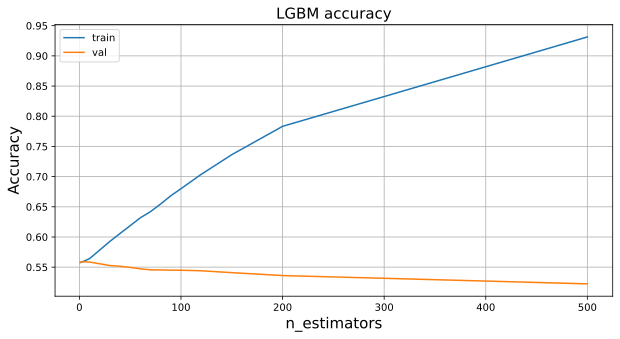

In [15]:
n_estimators = [1, 5, 10, 30, 40, 50, 60, 70, 80, 90, 100, 120, 150, 200, 500]
best_score, best_param = get_best_parameter(LGBMClassifier, 'LGBM', X_train, y_train, X_val, y_val, "n_estimators", n_estimators)

Заметим, что модель опять сильно переобучается. Возьмём 100 деревьев, чтобы не было сильного эффекта переобучения

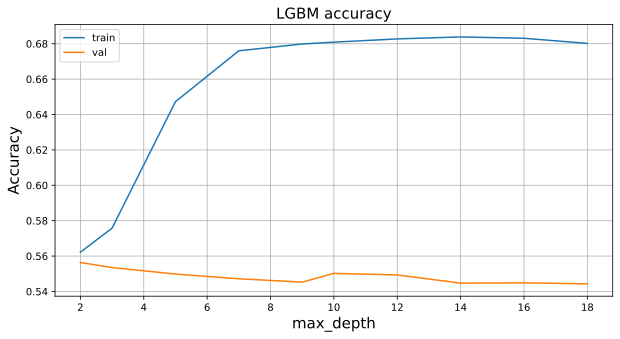

In [25]:
max_depth = np.linspace(2, 18, 10).astype('int')
params = {'n_estimators': 100}
best_score, best_param = get_best_parameter(LGBMClassifier, 'LGBM', X_train, y_train, X_val, y_val, "max_depth", max_depth, params)

In [26]:
best_score, best_param

(0.5563693952291399, 2)

Качество снова на валидации получилось примерно таким же. Возьмём деревья поглубже - 10.

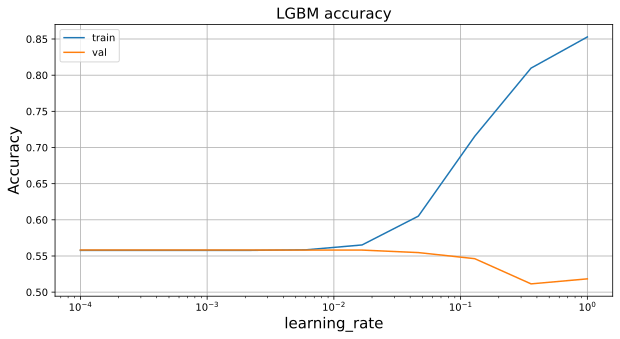

In [30]:
learning_rate = np.logspace(-4, 0, 10)
params['max_depth'] = 10
best_score, best_param = get_best_parameter(LGBMClassifier, 'LGBM', X_train, y_train, X_val, y_val, "learning_rate", learning_rate, params)

In [36]:
best_score, best_param

(0.5582500247451252, 0.0166810054)

In [33]:
params['learning_rate'] = 0.1
print_res(LGBMClassifier(**params), X, y, X_test, y_test, "LGBM")

LGBM train accuracy: 0.6672110944483214
LGBM test accuracy: 0.5217889908256881


# ELECTRA

Попробуем рассмотреть другой трансформер - **Electra**

In [22]:
from transformers import ElectraForSequenceClassification

In [26]:
electra = ElectraForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = True, # Whether the model returns all hidden-states.
)

for p in electra.parameters():
    p.requires_grad = False

pytorch_total_params = sum(p.numel() for p in electra.parameters() if p.requires_grad)
print('ELECTRA parameters: ', pytorch_total_params)

You are using a model of type bert to instantiate a model of type electra. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at bert-base-uncased were not used when initializing ElectraForSequenceClassification: ['bert.encoder.layer.5.attention.self.query.bias', 'bert.encoder.layer.6.attention.self.value.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.dense.bias', 'bert.encoder.layer.9.output.dense.bias', 'bert.encoder.layer.1.attention.self.query.bias', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.dense.weight', 'bert.encoder.layer.2.intermediate.dense.weight', 'bert.encoder.layer.6.output.LayerNorm.bias', 'bert.encoder.layer.11.attention.self.query.weight', 'bert.encoder.layer.5.output.dense.bias', 'bert.encoder.layer.4.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.self.key.bias', 'bert.encoder.layer.3.attention.outp

ELECTRA parameters:  0


In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
electra = electra.to(device)

Получим такие же DL-представления как и ранее для BERT

In [30]:
X_train_tokens, X_test_tokens, X_train_channels, X_test_channels, X_train_clc, X_test_clc = [], [], [], [], [], []
for idx, (inputs, labels) in enumerate(train_dataloader):
    inputs, labels = inputs.to(device), labels.to(device)
    out_electra = electra(inputs)[1][-1]
    X_train_tokens.append(out_electra.mean(axis=1).cpu())
    X_train_channels.append(out_electra.mean(axis=2).cpu())
    X_train_clc.append(out_electra[:, 0].cpu())

for idx, (inputs, labels) in enumerate(test_dataloader):
    inputs, labels = inputs.to(device), labels.to(device)
    out_electra = electra(inputs)[1][-1]
    X_test_tokens.append(out_electra.mean(axis=1).cpu())
    X_test_channels.append(out_electra.mean(axis=2).cpu())
    X_test_clc.append(out_electra[:, 0].cpu())

In [31]:
X_train_tokens = torch.cat(X_train_tokens, dim=0)
X_train_channels = torch.cat(X_train_channels, dim=0)
X_train_clc = torch.cat(X_train_clc, dim=0)

X_test_tokens = torch.cat(X_test_tokens, dim=0)
X_test_channels = torch.cat(X_test_channels, dim=0)
X_test_clc = torch.cat(X_test_clc, dim=0)

In [32]:
X_train_tokens.shape, X_test_tokens.shape, X_train_channels.shape, X_test_channels.shape, X_train_clc.shape, X_test_clc.shape

(torch.Size([67349, 768]),
 torch.Size([872, 768]),
 torch.Size([67349, 128]),
 torch.Size([872, 128]),
 torch.Size([67349, 768]),
 torch.Size([872, 768]))

In [34]:
torch.save(X_train_tokens, PATH + "X_train_electra_tokens")
torch.save(X_train_channels, PATH + "X_train_electra_channels")
torch.save(X_train_clc, PATH + "X_train_electra_clc")

torch.save(X_test_tokens, PATH + "X_test_electra_tokens")
torch.save(X_test_channels, PATH + "X_test_electra_channels")
torch.save(X_test_clc, PATH + "X_test_electra_clc")

Проведём такие же эксперименты, как и в 1 части, для градиентного бустинга.

## Среднее по токенам

In [ ]:
X = torch.load(PATH + "X_train_electra_tokens", map_location=torch.device('cpu'))
X_test = torch.load(PATH + "X_test_electra_tokens", map_location=torch.device('cpu'))

In [ ]:
X.shape, y.shape, X_test.shape, y_test.shape

(torch.Size([67349, 768]), (67349,), torch.Size([872, 768]), (872,))

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.15, shuffle=True, random_state=10)

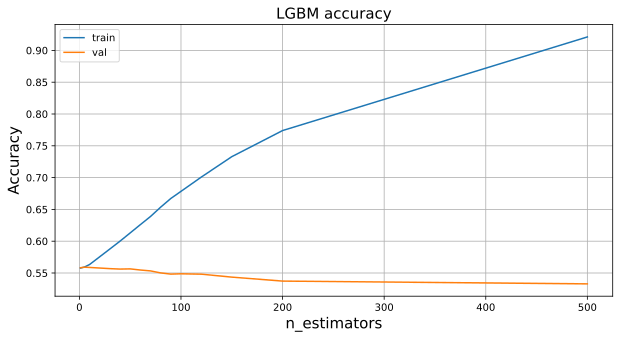

In [ ]:
n_estimators = [1, 5, 10, 30, 40, 50, 60, 70, 80, 90, 100, 120, 150, 200, 500]
best_score, best_param = get_best_parameter(LGBMClassifier, 'LGBM', X_train, y_train, X_val, y_val, "n_estimators", n_estimators)

In [ ]:
best_score, best_param

(0.5591408492526972, 60)

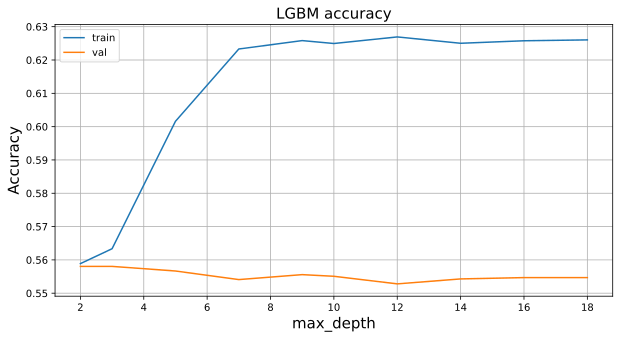

In [ ]:
max_depth = np.linspace(2, 18, 10).astype('int')
params = {'n_estimators': 60}
best_score, best_param = get_best_parameter(LGBMClassifier, 'LGBM', X_train, y_train, X_val, y_val, "max_depth", max_depth, params)

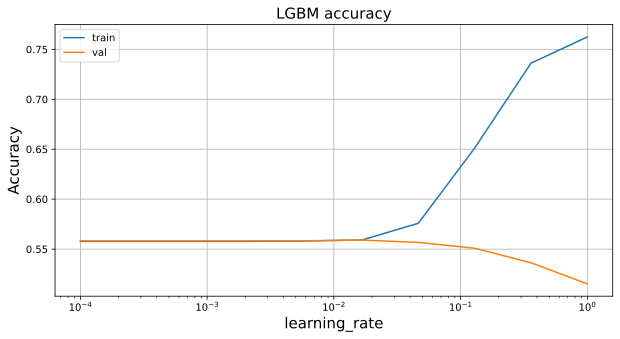

In [ ]:
learning_rate = np.logspace(-4, 0, 10)
params['max_depth'] = 18
best_score, best_param = get_best_parameter(LGBMClassifier, 'LGBM', X_train, y_train, X_val, y_val, "learning_rate", learning_rate, params)

In [ ]:
best_score, best_param

(0.5590418687518559, 0.016681005372000592)

In [ ]:
params['learning_rate'] = best_param
print_res(LGBMClassifier(**params), X, y, X_test, y_test, "LGBM")

LGBM train accuracy: 0.6156587328690849
LGBM test accuracy: 0.5206422018348624


## Среднее по каналам

In [37]:
X = torch.load(PATH + "X_train_electra_channels", map_location=torch.device('cpu'))
X_test = torch.load(PATH + "X_test_electra_channels", map_location=torch.device('cpu'))

In [38]:
X.shape, y.shape, X_test.shape, y_test.shape

(torch.Size([67349, 128]), (67349,), torch.Size([872, 128]), (872,))

In [39]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.15, shuffle=True, random_state=10)

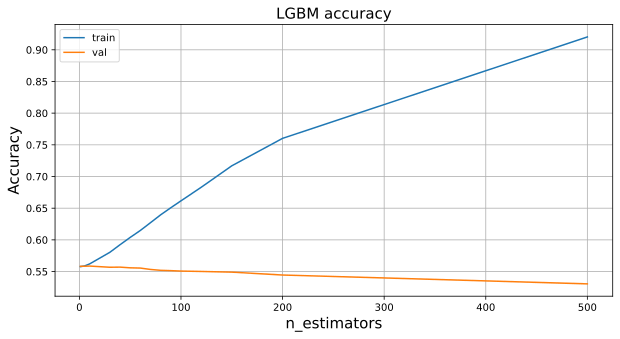

In [40]:
n_estimators = [1, 5, 10, 30, 40, 50, 60, 70, 80, 90, 100, 120, 150, 200, 500]
best_score, best_param = get_best_parameter(LGBMClassifier, 'LGBM', X_train, y_train, X_val, y_val, "n_estimators", n_estimators)

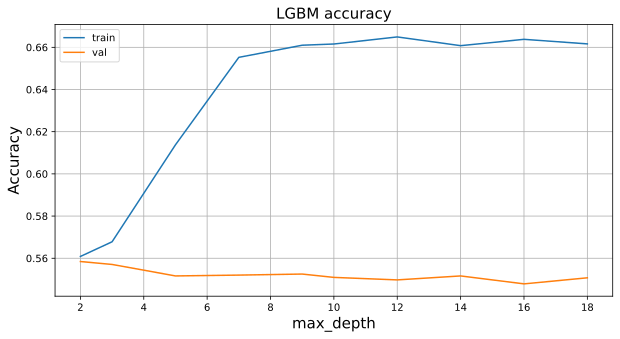

In [42]:
max_depth = np.linspace(2, 18, 10).astype('int')
params = {'n_estimators': 100}
best_score, best_param = get_best_parameter(LGBMClassifier, 'LGBM', X_train, y_train, X_val, y_val, "max_depth", max_depth, params)

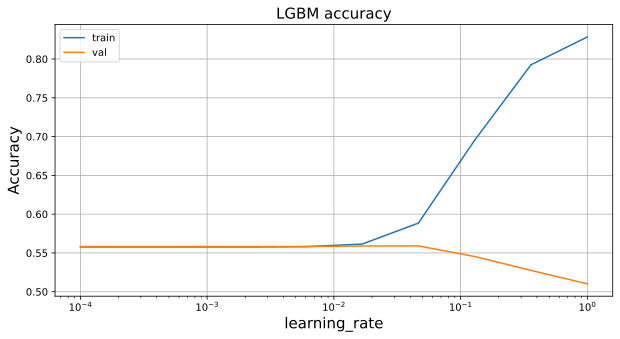

In [44]:
learning_rate = np.logspace(-4, 0, 10)
params['max_depth'] = 4
best_score, best_param = get_best_parameter(LGBMClassifier, 'LGBM', X_train, y_train, X_val, y_val, "learning_rate", learning_rate, params)

In [45]:
best_score, best_param

(0.5590418687518559, 0.046415888336127774)

In [46]:
params['learning_rate'] = best_param
print_res(LGBMClassifier(**params), X, y, X_test, y_test, "LGBM")

LGBM train accuracy: 0.5834978990036972
LGBM test accuracy: 0.5034403669724771


## Первый токен

In [47]:
X = torch.load(PATH + "X_train_electra_clc", map_location=torch.device('cpu'))
X_test = torch.load(PATH + "X_test_electra_clc", map_location=torch.device('cpu'))

In [48]:
X.shape, y.shape, X_test.shape, y_test.shape

(torch.Size([67349, 768]), (67349,), torch.Size([872, 768]), (872,))

In [50]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.15, shuffle=True, random_state=10)

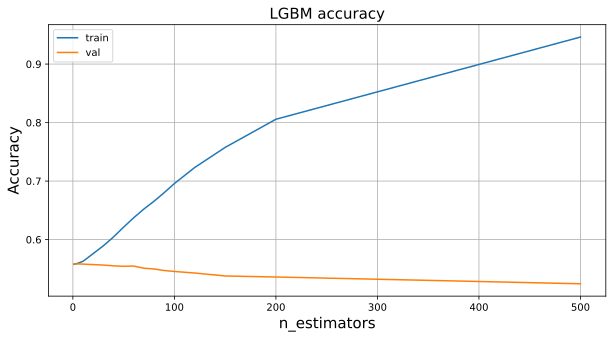

In [51]:
n_estimators = [1, 5, 10, 30, 40, 50, 60, 70, 80, 90, 100, 120, 150, 200, 500]
best_score, best_param = get_best_parameter(LGBMClassifier, 'LGBM', X_train, y_train, X_val, y_val, "n_estimators", n_estimators)

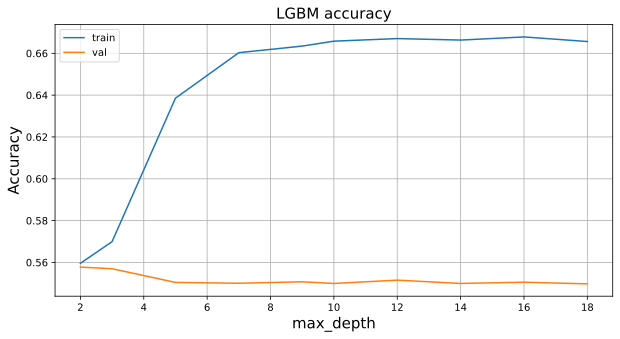

In [53]:
max_depth = np.linspace(2, 18, 10).astype('int')
params = {'n_estimators': 80}
best_score, best_param = get_best_parameter(LGBMClassifier, 'LGBM', X_train, y_train, X_val, y_val, "max_depth", max_depth, params)

In [61]:
best_score, best_param

(0.5577551222409185, 2)

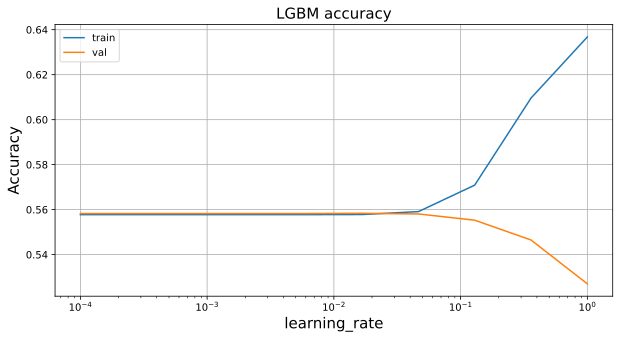

In [62]:
learning_rate = np.logspace(-4, 0, 10)
params['max_depth'] = 2
best_score, best_param = get_best_parameter(LGBMClassifier, 'LGBM', X_train, y_train, X_val, y_val, "learning_rate", learning_rate, params)

In [63]:
best_score, best_param

(0.5583490052459665, 0.016681005372000592)

In [67]:
params['learning_rate'] = best_param
print_res(LGBMClassifier(**params), X, y, X_test, y_test, "LGBM")

LGBM train accuracy: 0.6261265943072651
LGBM test accuracy: 0.5298165137614679


Получили схожие результаты для разных трансформеров и представлениям из них.

# Выводы

Можно заметить, что особо разницы между трансформерами, взятием DL-представлений из них и различными ML моделями нет. Все примерно одинаково и плохо обучаются и не способны показать хорошего качества. Возможно это связано с тем, что обычные ML алгоритмы не способны работать с таким представлением текста